In [26]:
import os
# import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from jupyterthemes import jtplot
jtplot.style(theme = 'monokai', context = 'notebook', ticks = True, grid = False) 

In [27]:
XRay_Directory = 'chestData/train'
os.listdir(XRay_Directory)

['Covid', 'Normal', 'Viral Pneumonia']

In [28]:
image_generator= ImageDataGenerator(rescale= 1./255, validation_split=0.2)

train_generator=image_generator.flow_from_directory(batch_size=40,
                                                    directory= XRay_Directory,
                                                    shuffle= True,
                                                    target_size=(256,256),
                                                    class_mode= 'categorical',
                                                    subset= 'training')

Found 201 images belonging to 3 classes.


In [29]:
validation_generator = image_generator.flow_from_directory(batch_size = 40,
                                                           directory = XRay_Directory, 
                                                           shuffle = True, 
                                                           target_size = (256,256), 
                                                           class_mode = 'categorical', 
                                                           subset = "validation")

Found 50 images belonging to 3 classes.


In [30]:
train_image,train_labels= next(train_generator)
train_image.shape
train_labels.shape

(40, 3)

In [31]:
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia'}

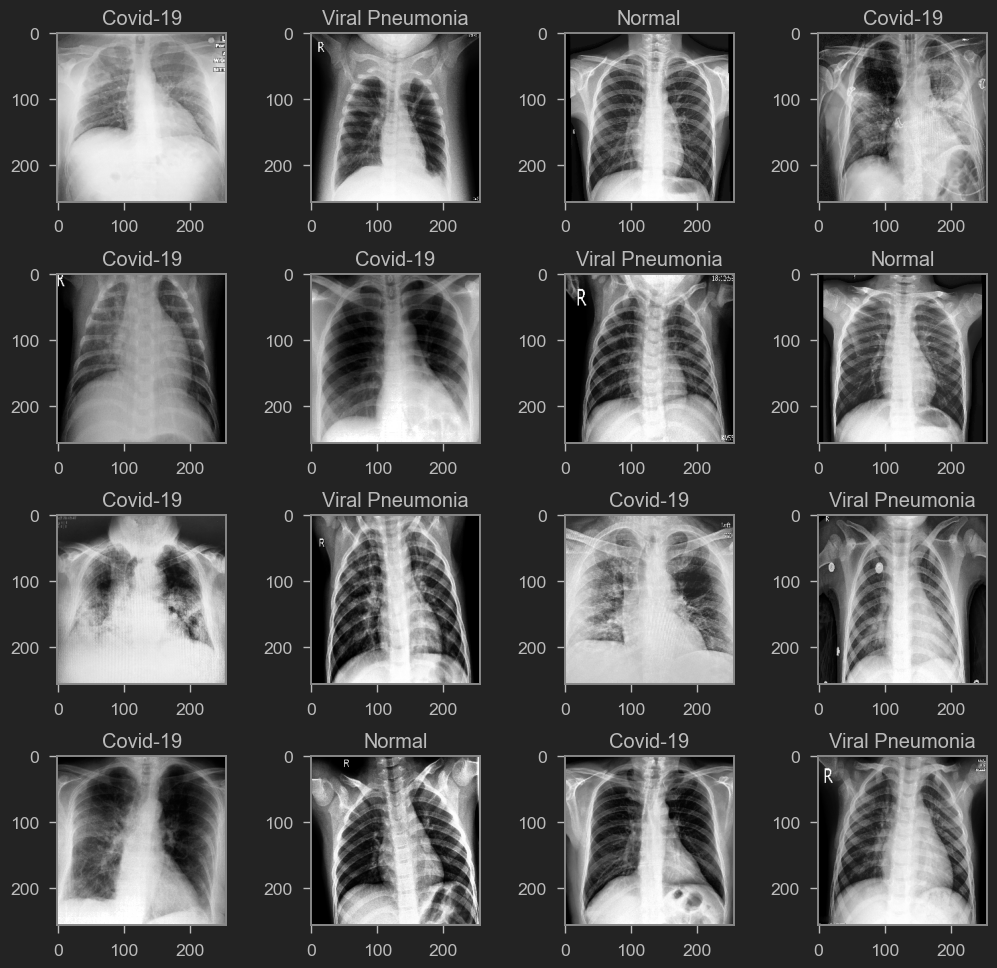

In [32]:
L = 4
W = 4

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_image[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    
    plt.subplots_adjust(wspace = 0.5)    

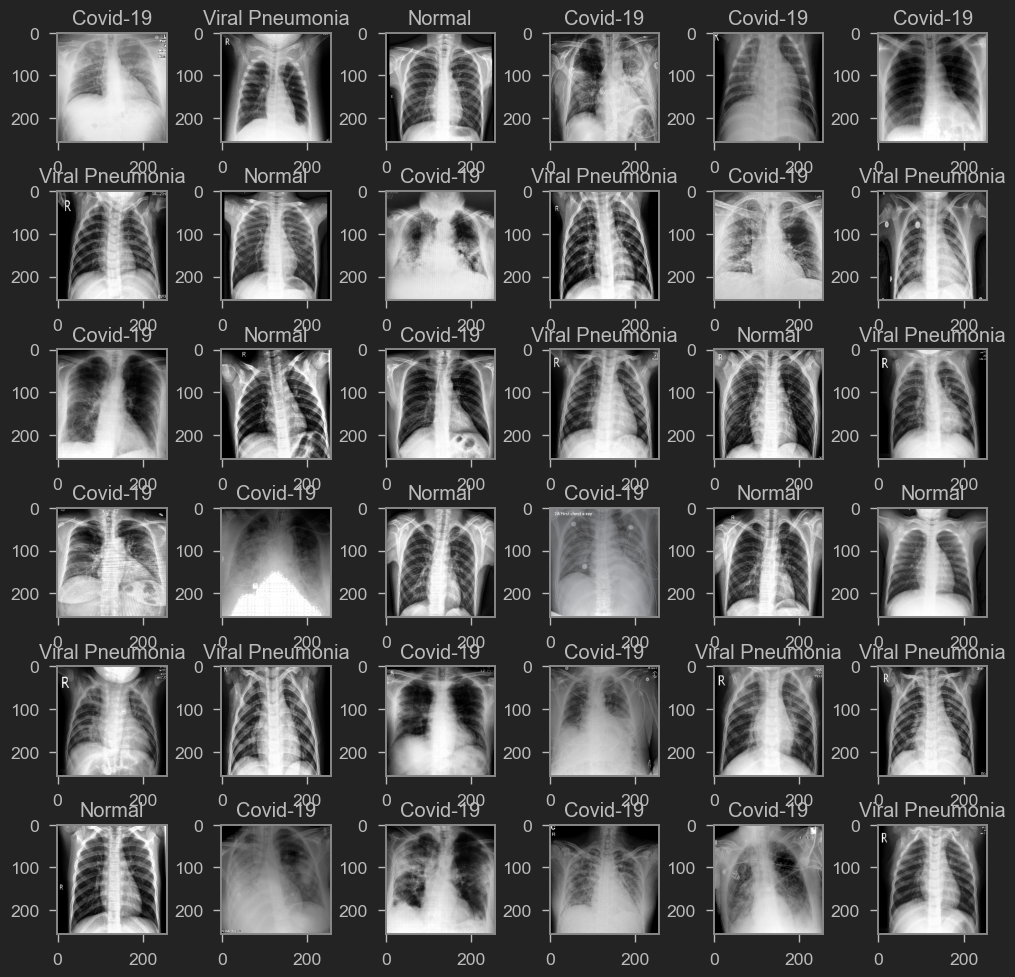

In [33]:
L = 6
W = 6

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_image[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    
    plt.subplots_adjust(wspace = 0.5)   

In [34]:
basemodel=ResNet50(weights='imagenet',include_top=False,input_tensor=Input(shape=(256,256,3)))
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [35]:
#for layer in basemodel.layers[:'10']:
 #   layers.trainable = False

In [36]:
headmodel=basemodel.output
headmodel=AveragePooling2D(pool_size=(4,4))(headmodel)
headmodel= Flatten(name='Flatten')(headmodel)
headmodel=Dense(256,activation= 'relu')(headmodel)
headmodel=Dropout(0.3)(headmodel)
headmodel=Dense(128,activation='relu')(headmodel)
headmodel=Dropout(0.2)(headmodel)

headmodel= Dense (4, activation= 'softmax')(headmodel)

model=Model(inputs= basemodel.input,outputs = headmodel)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [46]:
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])


SyntaxError: keyword argument repeated: optimizer (853711219.py, line 1)

In [38]:
# using early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# save the best model with lower validation loss
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)

In [39]:
train_generator = image_generator.flow_from_directory(batch_size = 3, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="training")
val_generator = image_generator.flow_from_directory(batch_size = 3, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode= 'categorical', subset="validation")

Found 201 images belonging to 3 classes.
Found 50 images belonging to 3 classes.


In [48]:
#history = model.fit(train_generator, steps_per_epoch= train_generator.n // 4, epochs = 10, validation_data= val_generator, validation_steps= val_generator.n // 4, callbacks=[checkpointer, earlystopping])
history = model.fit(train_image,train_labels,epochs=10)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "c:\Program Files\Python39\lib\runpy.py", line 197, in _run_module_as_main

  File "c:\Program Files\Python39\lib\runpy.py", line 87, in _run_code

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Program Files\Python39\lib\asyncio\base_events.py", line 601, in run_forever

  File "c:\Program Files\Python39\lib\asyncio\base_events.py", line 1905, in _run_once

  File "c:\Program Files\Python39\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\PC\AppData\Local\Temp\ipykernel_20936\1639546474.py", line 2, in <module>

  File "c:\Program Files\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1783, in fit

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1377, in train_function

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1360, in step_function

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1349, in run_step

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1127, in train_step

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Program Files\Python39\lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Program Files\Python39\lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Program Files\Python39\lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy

  File "c:\Program Files\Python39\lib\site-packages\keras\src\backend.py", line 5581, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,4] labels_size=[32,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_37708]

In [ ]:
model.compile(optimizer=tf.keras.optimizers.legacy.RMSprop(0.0001, decay=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])
test_directory = 'chestData/test'
test_gen = ImageDataGenerator(rescale = 1./255)

test_generator = test_gen.flow_from_directory(batch_size = 40, directory= test_directory, shuffle= True, target_size=(256,256), class_mode= 'categorical')

evaluate = model.evaluate(test_generator, steps=test_generator.n // 4, verbose=1)

print('Accuracy Test : {}'.format(evaluate[1]))

Found 66 images belonging to 3 classes.


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "c:\Program Files\Python39\lib\runpy.py", line 197, in _run_module_as_main

  File "c:\Program Files\Python39\lib\runpy.py", line 87, in _run_code

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 1043, in launch_instance

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 736, in start

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 195, in start

  File "c:\Program Files\Python39\lib\asyncio\base_events.py", line 601, in run_forever

  File "c:\Program Files\Python39\lib\asyncio\base_events.py", line 1905, in _run_once

  File "c:\Program Files\Python39\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 740, in execute_request

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 422, in do_execute

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 546, in run_cell

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes

  File "C:\Users\PC\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code

  File "C:\Users\PC\AppData\Local\Temp\ipykernel_20936\2885041396.py", line 7, in <module>

  File "c:\Program Files\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 2272, in evaluate

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 4079, in run_step

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 2042, in test_function

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 2025, in step_function

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 2013, in run_step

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1895, in test_step

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\training.py", line 1185, in compute_loss

  File "c:\Program Files\Python39\lib\site-packages\keras\src\engine\compile_utils.py", line 277, in __call__

  File "c:\Program Files\Python39\lib\site-packages\keras\src\losses.py", line 143, in __call__

  File "c:\Program Files\Python39\lib\site-packages\keras\src\losses.py", line 270, in call

  File "c:\Program Files\Python39\lib\site-packages\keras\src\losses.py", line 2221, in categorical_crossentropy

  File "c:\Program Files\Python39\lib\site-packages\keras\src\backend.py", line 5581, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[40,4] labels_size=[40,3]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_test_function_6533]

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import cv2
prediction = []
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
    img= cv2.imread(os.path.join(test_directory,str(i),item))
    img = cv2.resize(img,(256,256))
    image.append(img)
    img = img / 255
    img = img.reshape(-1,256,256,3)
    predict = model.predict(img)
    predict = np.argmax(predict)
    prediction.append(predict)
    original.append(i)